In [3]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import yfinance as yf
import datetime
from datetime import timedelta

# Fetching Information

First we will fetch all the finantial information regarding the stock whose price we will attempt to predict. Then, we will keep only the close price for each day, and we will graph this. Lastly, we want to train out newral network with about 80% of our available data, so we will calculate how many registers this is.

In [4]:
AXAS_stock_information = yf.download('AXAS', start = '2015-07-15', end = '2019-07-14') # Fetching apple information
AXAS_stock_information.to_csv('AXAS.csv')

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'Historic close price for AXAS'}, xlabel='Date', ylabel='Close Price USD ($)'>

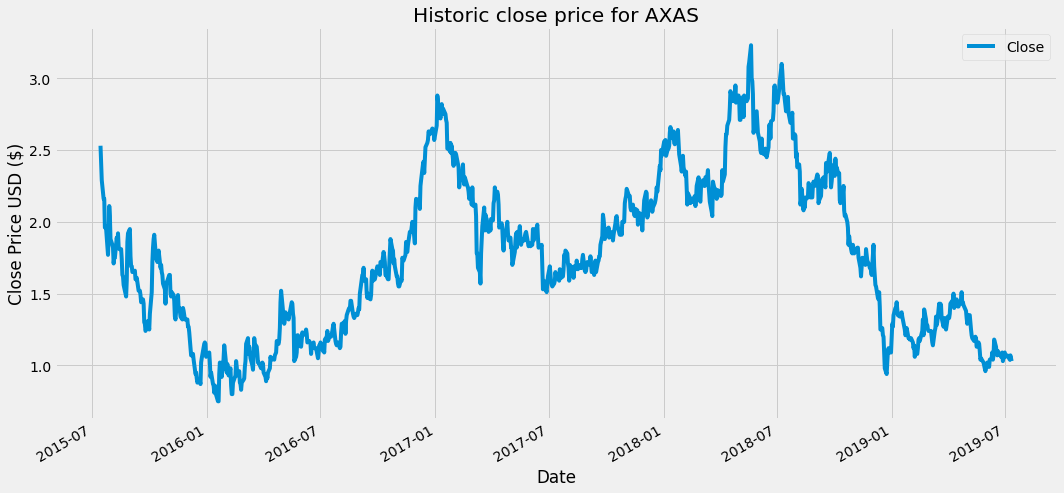

In [5]:
AXAS_close_price = AXAS_stock_information.filter(['Close']) # Droppping everything that isn't close price
AXAS_close_price.plot(title = 'Historic close price for AXAS', figsize=(16,8), xlabel = 'Date', ylabel = 'Close Price USD ($)') # Graphing

In [6]:
training_data_len = math.ceil( AXAS_close_price.shape[0] *.8) # Calculates number of training registers
training_data_len

805

# Scaling

Now we will scale oll of our closing prices on a scale of 0 to 1, inclusive. This is generally a good practice when it comes to neural networks. We will use the MinMax method, which goes as follows:

$ X_{new} = \frac{X - X_{min}}{X_{max}-X_{min}} $

For time's sake, we will use the preimplemented MinMaxScaler package of the python *sklean* library. But, before we do this, we must make one last trasformation. Up until now we have been storing our closing prices in a *pandas* dataframe, but the pre-imlemented MinMaxScaler requires an array input, probably because the operations required to find the largest and smallest numbers iun this data structure are long, therefore we will transform this *pandas* dataset into a *numpy* array, in which theses operations can be done faster.

In [7]:
array_of_closing_values = AXAS_close_price.values # Transfor the dataframe into an array

scaler = MinMaxScaler(feature_range=(0, 1)) # Instanciate a MinMaxScaler with a [0,1] range
scaled_close_prices = scaler.fit_transform(array_of_closing_values) # Pass the data to the scaler, for it to scale it :)

scaled_close_prices

array([[0.71774192],
       [0.66935487],
       [0.62096772],
       ...,
       [0.12903228],
       [0.12096772],
       [0.11290321]])

# Creating the Training Data

For this problem in particular we will create 2 data sub-sets. The first one we will call independent train or $x train$ and the decond one we will call dependant train, or $y train$. The independant train will have sets of 60 days worth of information, and the dependant train will store the closing price information for the day after the ones stored in the $x train$ position with the same index.

In [8]:
train_data = scaled_close_prices[0:training_data_len , : ] # Selects from the scaled prices the number of rows defined as training_data_len
print(train_data)

# Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for row in range(60, len(train_data)):
    x_train.append(train_data[row-60:row,0])
    y_train.append(train_data[row,0])
    
# Turn the x and y trains into arrays, because the neural network trainer only takes 3-dimentional arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

[[0.71774192]
 [0.66935487]
 [0.62096772]
 [0.56854842]
 [0.56854842]
 [0.48790324]
 [0.49193549]
 [0.48387098]
 [0.41129031]
 [0.45564516]
 [0.54838705]
 [0.52016127]
 [0.45564516]
 [0.43951614]
 [0.43145163]
 [0.38709679]
 [0.4032258 ]
 [0.4032258 ]
 [0.45967741]
 [0.43951614]
 [0.47177417]
 [0.43548388]
 [0.42741933]
 [0.42741933]
 [0.39919355]
 [0.35483871]
 [0.35080645]
 [0.32661288]
 [0.30241935]
 [0.29435484]
 [0.33870969]
 [0.44758065]
 [0.47177417]
 [0.48387098]
 [0.40725806]
 [0.37903228]
 [0.37903228]
 [0.36290321]
 [0.36693547]
 [0.34274194]
 [0.34274194]
 [0.3467742 ]
 [0.31048386]
 [0.31048386]
 [0.31048386]
 [0.2983871 ]
 [0.27822583]
 [0.28629034]
 [0.27419353]
 [0.22177417]
 [0.21774192]
 [0.19758065]
 [0.20967741]
 [0.22580643]
 [0.21370966]
 [0.2016129 ]
 [0.24596775]
 [0.30645161]
 [0.39112904]
 [0.43145163]
 [0.45564516]
 [0.46774192]
 [0.39919355]
 [0.4032258 ]
 [0.39112904]
 [0.41129031]
 [0.42338707]
 [0.37499998]
 [0.38306453]
 [0.36290321]
 [0.35483871]
 [0.33

# Building the Model

In [9]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=1)

745/745 [==============================] - 29s 38ms/step - loss: 0.0073


In [10]:
test_data = scaled_close_prices[training_data_len - 60: , : ] # We declare the test data to be the last 20% of out total information

#Create the x_test and y_test data sets
x_test = []
y_test =  array_of_closing_values[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [11]:
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions) # Undo scaling

<ipython-input-12-f76a5df10a65>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


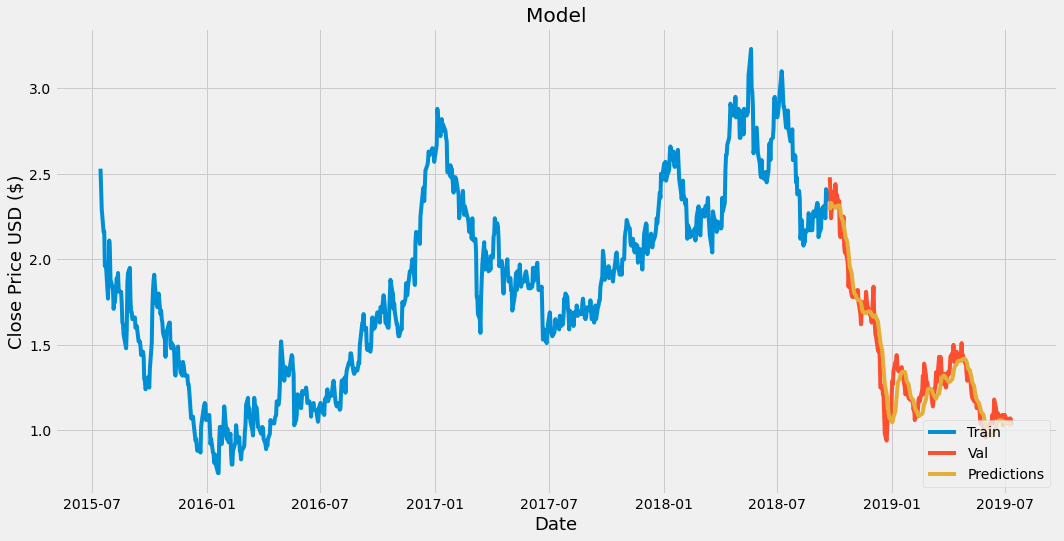

In [12]:
#Plot/Create the data for the graph
train = AXAS_close_price[:training_data_len]
valid = AXAS_close_price[training_data_len:]
valid['Predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [13]:
pd.set_option('display.max_rows', 10)
valid[['Close', 'Predictions']]

,Close,Predictions
Date,,
2018-09-24,2.48,2.287644
2018-09-25,2.39,2.313025
2018-09-26,2.24,2.329818
2018-09-27,2.28,2.325312
2018-09-28,2.33,2.314355
...,...,...
2019-07-08,1.05,1.038424
2019-07-09,1.04,1.035457
2019-07-10,1.07,1.031209


In [14]:
array_of_predictions = valid[['Predictions']].values
array_of_real_prices = valid[['Close']].values

success = 0

for i in range (array_of_predictions.shape[0] - 1):
    if ((array_of_predictions[i] <= array_of_predictions[i + 1]) and (array_of_real_prices[i] <= array_of_real_prices[i + 1])):
        success = success + 1
    elif ((array_of_predictions[i] > array_of_predictions[i + 1]) and (array_of_real_prices[i] > array_of_real_prices[i + 1])):
        success = success + 1
        
failure = array_of_predictions.shape[0] - success


print(f'Success = {success}, Failure = {failure}')

Success = 102, Failure = 99
